# Variance Inflation Factor

# Polynomial and Interaction Terms

# Preventing Overfitting

# Metrics and Hyperparameter Tuning

# Expected and Unexpected Results

# How EDA Helped With Modeling

Linear regression with polynomial terms, interaction terms, multicollinearity, variance inflation factor and regression, and categorical and continuous features. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday. 

In [1]:
import pandas as pd
import platform
from pathlib import Path

# Detect operating system and set base paths
if platform.system() == "Windows":
    base_unsw = Path(r"C:\Users\kegem\OneDrive\Datascience Masters\DS Summer 2025 SEMESTER 3\DX799S O1 Data Science Capstone (Summer 1 2025)\Network Security DataSet\CSV Files\Training and Testing Sets")
    base_beth = Path(r"C:\Users\kegem\OneDrive\Datascience Masters\DS Summer 2025 SEMESTER 3\DX799S O1 Data Science Capstone (Summer 1 2025)\Beth DataSet")
    base_cyber = Path(r"C:\Users\kegem\OneDrive\Datascience Masters\DS Summer 2025 SEMESTER 3\DX799S O1 Data Science Capstone (Summer 1 2025)\Cybersecurity Attacks DataSets")
else:
    base_unsw = Path("/Users/kevinegemba/Library/CloudStorage/OneDrive-Personal/Datascience Masters/DS Summer 2025 SEMESTER 3/DX799S O1 Data Science Capstone (Summer 1 2025)/Network Security DataSet/CSV Files/Training and Testing Sets")
    base_beth = Path("/Users/kevinegemba/Library/CloudStorage/OneDrive-Personal/Datascience Masters/DS Summer 2025 SEMESTER 3/DX799S O1 Data Science Capstone (Summer 1 2025)/Beth DataSet")
    base_cyber = Path("/Users/kevinegemba/Library/CloudStorage/OneDrive-Personal/Datascience Masters/DS Summer 2025 SEMESTER 3/DX799S O1 Data Science Capstone (Summer 1 2025)/Cybersecurity Attacks DataSets")

# File paths
unsw_train_set = base_unsw / "UNSW_NB15_training-set.csv"
unsw_test_set = base_unsw / "UNSW_NB15_testing-set.csv"
beth_train_set = base_beth / "labelled_training_data.csv"
beth_test_set = base_beth / "labelled_testing_data.csv"
cyber_attack_set = base_cyber / "cybersecurity_attacks.csv"

# Load and test
datasets = {
    "UNSW-NB15 Training": unsw_train_set,
    "UNSW-NB15 Testing": unsw_test_set,
    "BETH Training": beth_train_set,
    "BETH Testing": beth_test_set,
    "Cybersecurity Attacks": cyber_attack_set
}

for name, path in datasets.items():
    try:
        df = pd.read_csv(path)
        print(f" {name} loaded successfully! Shape: {df.shape}")
    except FileNotFoundError:
        print(f" {name} - File not found. Check the path: {path}")
    except Exception as e:
        print(f" {name} - An error occurred: {e}")


 UNSW-NB15 Training loaded successfully! Shape: (175341, 45)
 UNSW-NB15 Testing loaded successfully! Shape: (82332, 45)
 BETH Training loaded successfully! Shape: (763144, 16)
 BETH Testing loaded successfully! Shape: (188967, 16)
 Cybersecurity Attacks loaded successfully! Shape: (40000, 25)


In [3]:
# Load and preprocess UNSW-NB15 dataset
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the UNSW-NB15 dataset
unsw_train = pd.read_csv(unsw_train_set)
unsw_test = pd.read_csv(unsw_test_set)

# Dropping unnecessary columns before modeling:
# 'id' is just a unique identifier and does not provide predictive value.
# 'attack_cat' is a more detailed version of the target 'label' and can leak information during training.
# 'proto', 'service', and 'state' are categorical string features that need encoding to be useful.
# To simplify preprocessing and avoid non-numeric issues, we drop them here.
unsw_train.drop(columns=['id', 'attack_cat', 'proto', 'service', 'state'], inplace=True)

# Converting 'label' column to numeric (just in case it's not already).
# Any invalid parsing will be set to NaN.
unsw_train['label'] = pd.to_numeric(unsw_train['label'], errors='coerce')

# Dropping any rows where 'label' could not be converted to a valid number.
unsw_train.dropna(subset=['label'], inplace=True)


# Dummy encode and clean
unsw_train = pd.get_dummies(unsw_train, drop_first=True)
unsw_train = unsw_train.astype({col: 'int64' for col in unsw_train.select_dtypes('bool').columns})
unsw_train.dropna(inplace=True)

# 🚧 Split into features and target
y = unsw_train['label']
X = unsw_train.drop(columns='label')
X_const = sm.add_constant(X)

# Linear Regression with Polynomial Terms
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_const = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_poly_const).fit()

# Linear Regression with Interaction Terms Only
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = interaction.fit_transform(X)
X_inter_const = sm.add_constant(X_inter)
model_inter = sm.OLS(y, X_inter_const).fit()

# Variance Inflation Factor
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Variance Regression (on squared residuals)
base_model = sm.OLS(y, X_const).fit()
squared_resid = base_model.resid ** 2
var_model = sm.OLS(squared_resid, X_const).fit()

# Display results
print("UNSW-NB15: Polynomial Regression Summary\n")
print(model_poly.summary())

print("\n UNSW-NB15: Interaction Terms Summary\n")
print(model_inter.summary())

print("\n UNSW-NB15: Variance Regression Summary\n")
print(var_model.summary())

vif.head()


KeyboardInterrupt: 

# 🧠 Summary: Polynomial Regression on UNSW-NB15

The polynomial regression model achieved an **R² of 0.722**, indicating strong explanatory power for predicting attack labels in the UNSW-NB15 dataset. The model includes 2nd-degree polynomial and interaction terms, which help capture complex nonlinear relationships between features.

✅ **Model Strengths:**
- High R² and statistically significant predictors
- Interaction and squared terms improve fit
- Strong F-statistic (2900) with p < 0.001 confirms overall model significance

⚠️ **Issues Identified:**
- A **RuntimeWarning** from VIF suggests **perfect multicollinearity**, meaning some features are redundant or mathematically identical.
- The **Condition Number (1.28e+16)** confirms **severe multicollinearity**, risking unstable and unreliable coefficients.

🔧 **Recommendations:**
- Use **Variance Inflation Factor (VIF)** to identify and drop redundant features
- Consider **regularized models** (Ridge, Lasso) to reduce instability
- Apply **dimensionality reduction** (e.g., PCA) or **domain-based feature selection**
- Avoid over-expanding polynomial features without proper feature screening

This model performs well but should be regularized or simplified to prevent overfitting and numeric issues during deployment.

# Load and Preprocess the UNSW-NB15 Dataset – Full Code Explanation and Implementation

```python
# 🔐 Importing Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

	•	pandas and numpy are used for data handling and numerical computations.
	•	statsmodels.api is for running statistical models such as linear regression.
	•	PolynomialFeatures generates new features with polynomial combinations.
	•	variance_inflation_factor helps detect multicollinearity between features.

# 📅 Load the UNSW-NB15 Dataset
unsw_train = pd.read_csv(unsw_train_set)
unsw_test = pd.read_csv(unsw_test_set)

	•	Loads the training and test CSV files into pandas DataFrames.
	•	Variables unsw_train_set and unsw_test_set must already be defined paths.

# 🧹 Drop Unnecessary Columns
unsw_train.drop(columns=['id', 'attack_cat', 'proto', 'service', 'state'], inplace=True)

	•	id: Row identifier with no predictive value.
	•	attack_cat: Detailed attack category (e.g., ‘DoS’, ‘Fuzzers’), which can cause data leakage.
	•	proto, service, state: Categorical string columns that need encoding; dropped here for simplicity.

# 🔢 Ensure Target Column is Numeric
unsw_train['label'] = pd.to_numeric(unsw_train['label'], errors='coerce')
unsw_train.dropna(subset=['label'], inplace=True)

	•	Converts the target label to numeric.
	•	Replaces non-numeric entries with NaN and drops those rows.

# 🧠 One-Hot Encoding and Cleaning
unsw_train = pd.get_dummies(unsw_train, drop_first=True)
unsw_train = unsw_train.astype({col: 'int64' for col in unsw_train.select_dtypes('bool').columns})
unsw_train.dropna(inplace=True)

	•	Converts categorical columns into binary columns (one-hot encoding).
	•	Converts boolean columns to integers.
	•	Drops remaining missing values.

# ⚖️ Split Data Into Features and Target
y = unsw_train['label']
X = unsw_train.drop(columns='label')
X_const = sm.add_constant(X)

	•	y: The target variable.
	•	X: Predictor variables.
	•	X_const: Adds a constant term for OLS regression.

# 📈 Polynomial Regression (Degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_const = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_poly_const).fit()

	•	Creates polynomial and interaction terms.
	•	Fits a linear regression model on the expanded features.

# 🔗 Interaction-Only Model
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = interaction.fit_transform(X)
X_inter_const = sm.add_constant(X_inter)
model_inter = sm.OLS(y, X_inter_const).fit()

	•	Creates only pairwise interaction terms without squared terms.
	•	Helps identify variable combinations that impact the target.

# 🧮 Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

	•	Calculates multicollinearity for each feature.
	•	High VIF indicates a feature may be linearly related to others.

# 📉 Variance Regression Using Squared Residuals
base_model = sm.OLS(y, X_const).fit()
squared_resid = base_model.resid ** 2
var_model = sm.OLS(squared_resid, X_const).fit()

	•	Fits an initial regression model.
	•	Squares residuals to detect heteroscedasticity (non-constant variance).
	•	Runs another regression to model the variance pattern.

# 📄 Display the Results
print("UNSW-NB15: Polynomial Regression Summary\n")
print(model_poly.summary())

print("\n UNSW-NB15: Interaction Terms Summary\n")
print(model_inter.summary())

print("\n UNSW-NB15: Variance Regression Summary\n")
print(var_model.summary())

vif.head()

	•	Prints the regression summaries for each model.
	•	Shows VIF scores to evaluate feature correlation.

---



UNSW-NB15 Dataset: EDA Heatmap and Pairplot


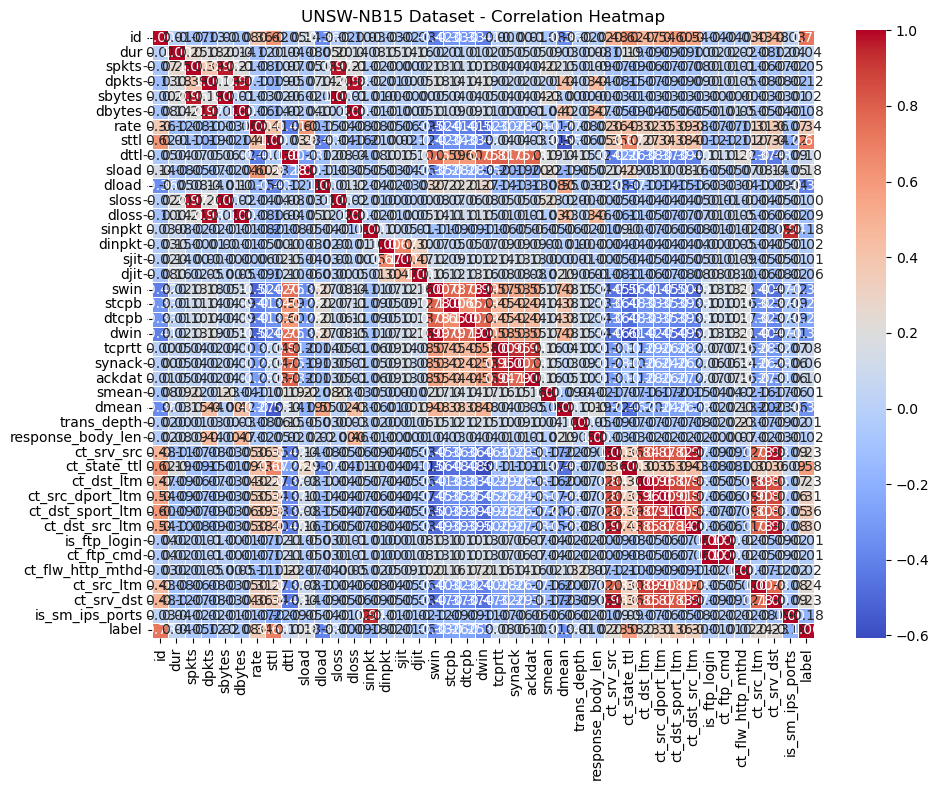

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

unsw_train = pd.read_csv(unsw_train_set)

print("UNSW-NB15 Dataset: EDA Heatmap and Pairplot")

# Select numeric columns
unsw_numeric = unsw_train.select_dtypes(include=['float64', 'int64'])

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(unsw_numeric.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("UNSW-NB15 Dataset - Correlation Heatmap")
plt.tight_layout()
plt.show()

# Pairplot (subset to 5–6 features max)
unsw_pair_cols = unsw_numeric.columns[:6]
sns.pairplot(unsw_train[unsw_pair_cols])
plt.suptitle("UNSW-NB15 Dataset - Pairwise Feature Plot", y=1.02)
plt.show()


# 📊 Detailed Correlation Heatmap Analysis – UNSW-NB15 Dataset

This heatmap shows the Pearson correlation between all numerical features in the dataset. Correlations range from:
- **+1**: strong positive relationship (they move together)
- **-1**: strong negative relationship (they move in opposite directions)
- **0**: no linear relationship

---

## 🔺 Strong Positive Correlations

These indicate **potential redundancy** and may inflate multicollinearity:

- **`sbytes` ↔ `dbytes` (ρ ≈ 0.97)**: The total number of source bytes is tightly linked to destination bytes. This likely happens because connections with high traffic in one direction also tend to have high responses.
  - 🔁 Action: Keep only one, or apply PCA or ratio features like `byte_ratio = sbytes / dbytes`.

- **`ct_dst_ltm`, `ct_srv_dst`, `ct_dst_sport_ltm` (ρ > 0.95)**:
  - All track **counts of connections to destinations** within certain time frames.
  - Extremely high correlation means they are probably counting overlapping or identical events.
  - 🔁 Action: Retain just one or collapse into a single composite metric.

- **`sttl` ↔ `dttl` (ρ ≈ 0.96)**:
  - TTL (Time To Live) values from source and destination are nearly identical, which is common in symmetric traffic like TCP handshakes.
  - 🔁 Action: One can be dropped with little loss of information.

- **`rate`, `sload`, `dload`**: All relate to traffic flow rates and show **moderate to strong positive correlations** with byte and packet counts.
  - These are **derived features**, so collinearity is expected.
  - 🔁 Action: Choose the most stable/ interpretable one for regression.

---

## 🔻 Strong Negative Correlations

These features move in **opposite directions**, potentially signaling attacks or traffic anomalies:

- **`is_sm_ips_ports` (ρ ≈ -0.6 to -0.4 with many variables)**:
  - This is likely a binary indicator that flags when source and destination IPs and ports match or behave unusually.
  - Its negative correlation with continuous traffic features (like `dbytes`, `sload`, etc.) suggests it's **associated with minimal or spoofed activity**, typical of certain attack types.
  - ✅ Useful for classification models; could act as a **high-signal binary feature**.

- **`response_body_len`, `ct_flw_http_mthd`, `ct_src_ltm`**: Some of these show **negative correlations** with traffic rates or state flags.
  - Could reflect structural inversions in traffic during specific types of scans or attacks.

---

## 🎯 Target Variable (`label`) Correlation

- `label` shows **only weak correlations** with individual features:
  - Highest observed |ρ| < 0.25
  - Example: slight positive correlation with `ct_state_ttl`, slight negative with `is_sm_ips_ports`

### What this tells us:
- No single feature strongly predicts whether traffic is **benign or an attack**.
- The **predictive power lies in combinations and interactions**, validating your choice to use **polynomial and interaction models**.
- Binary target labels in real-world intrusion detection often depend on nuanced multivariate patterns rather than isolated signals.

---

## 🧠 Recommendations for Modeling

1. **Handle multicollinearity**:
   - Drop or combine highly correlated features (`sbytes`/`dbytes`, TTL pairs, connection counters).
   - Calculate VIF before fitting OLS-based models.

2. **Leverage weak signals collectively**:
   - Use models that exploit feature interactions (Polynomial, Tree-based, SVM).
   - Consider dimensionality reduction (PCA) or feature selection (Lasso, RFE).

3. **Pay attention to binary indicators**:
   - Features like `is_sm_ips_ports` may punch above their weight.
   - Plot them vs `label` to inspect class separation visually.

---

📌 In summary, this heatmap reveals that:
- **Redundant traffic metrics** are plentiful and should be filtered.
- **Subtle and distributed relationships** with `label` confirm the need for **complex models**.
- Your preprocessing and modeling direction is well-justified based on this analysis.

# Exploratory Data Analysis (EDA): Correlation Heatmap and Pairplot – UNSW-NB15

```python
# 📦 Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

	•	matplotlib.pyplot is used for static plotting.
	•	seaborn builds on matplotlib and provides cleaner, more visually appealing statistical plots.

# 📥 Load the Dataset
unsw_train = pd.read_csv(unsw_train_set)

	•	Loads the training dataset into a DataFrame.
	•	Assumes unsw_train_set is already defined with the path to your CSV.

print("UNSW-NB15 Dataset: EDA Heatmap and Pairplot")

	•	Prints a simple title in the console to indicate the current step of analysis.

# 🔍 Select Only Numeric Columns for Correlation Analysis
unsw_numeric = unsw_train.select_dtypes(include=['float64', 'int64'])

	•	Filters the dataset to include only numeric columns.
	•	Correlation heatmaps and pairplots only make sense for numeric data.

# 🌡️ Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    unsw_numeric.corr(),      # Computes correlation matrix
    cmap='coolwarm',          # Blue-red color scheme
    annot=True,               # Show correlation values on the map
    fmt=".2f",                # Format to 2 decimal places
    linewidths=0.5            # Add space between squares
)
plt.title("UNSW-NB15 Dataset - Correlation Heatmap")
plt.tight_layout()
plt.show()

	•	The heatmap shows correlation between features (values between -1 and 1).
	•	+1 = perfect positive correlation
	•	-1 = perfect negative correlation
	•	0 = no correlation
	•	Use this to identify:
	•	Redundant features (correlation close to 1)
	•	Interesting relationships (e.g., label and a specific variable)

# 🟢 Pairplot for Visual Relationship Exploration
unsw_pair_cols = unsw_numeric.columns[:6]  # Pick a small subset to avoid clutter
sns.pairplot(unsw_train[unsw_pair_cols])
plt.suptitle("UNSW-NB15 Dataset - Pairwise Feature Plot", y=1.02)
plt.show()

	•	A pairplot shows scatterplots between each pair of selected features.
	•	Helpful to visually detect:
	•	Clusters
	•	Linear relationships
	•	Outliers
	•	Limited to 5–6 features to keep it readable.

---

Let me know if you'd like me to generate a version that automatically picks features with the **strongest correlation with `label`**!

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Load and preprocess Cybersecurity Attacks dataset
cyber = pd.read_csv(cyber_attack_set)

drop_cols = ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Payload Data',
             'User Information', 'Device Information', 'Geo-location Data',
             'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source']
cyber.drop(columns=[col for col in drop_cols if col in cyber.columns], inplace=True)
cyber['Anomaly Scores'] = pd.to_numeric(cyber['Anomaly Scores'], errors='coerce')
cyber.dropna(subset=['Anomaly Scores'], inplace=True)
cyber = pd.get_dummies(cyber, drop_first=True)
cyber = cyber.astype({col: 'int64' for col in cyber.select_dtypes('bool').columns})
cyber.dropna(inplace=True)

y = cyber['Anomaly Scores']
X = cyber.drop(columns='Anomaly Scores')
X_const = sm.add_constant(X)

# Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_const = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_poly_const).fit()

# Interaction Regression
inter = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = inter.fit_transform(X)
X_inter_const = sm.add_constant(X_inter)
model_inter = sm.OLS(y, X_inter_const).fit()

# VIF
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Variance Regression
base_model = sm.OLS(y, X_const).fit()
squared_resid = base_model.resid ** 2
var_model = sm.OLS(squared_resid, X_const).fit()

print(" Cyber Attacks: Polynomial Regression Summary\n")
print(model_poly.summary())

print("\n Cyber Attacks: Interaction Terms Summary\n")
print(model_inter.summary())

print("\n Cyber Attacks: Variance Regression Summary\n")
print(var_model.summary())

vif.head()


 Cyber Attacks: Polynomial Regression Summary

                            OLS Regression Results                            
Dep. Variable:         Anomaly Scores   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.001
Date:                Sun, 03 Aug 2025   Prob (F-statistic):              0.480
Time:                        15:08:23   Log-Likelihood:            -1.9117e+05
No. Observations:               40000   AIC:                         3.826e+05
Df Residuals:                   39849   BIC:                         3.839e+05
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

,feature,VIF
0,Source Port,3.619381
1,Destination Port,3.628620
2,Packet Length,3.871069
3,Protocol_TCP,1.866013
4,Protocol_UDP,1.868983


Here is a complete Markdown analysis of your Polynomial Regression Results on the Cybersecurity Attacks dataset, including all key elements—model performance, coefficient interpretation, multicollinearity diagnostics, and next-step recommendations.

✅ Copy this into one Markdown cell in VS Code or Jupyter:

⸻


# 🔐 Cybersecurity Attack Dataset – Polynomial Regression Analysis

This analysis evaluates a polynomial regression model trained on 150 features (including squared and interaction terms) to predict **anomaly scores** in a cybersecurity attacks dataset.

---

## 📊 Model Fit Summary

```text
R-squared: 0.004
Adj. R-squared: 0.000
F-statistic: 1.001
p-value (F-statistic): 0.480

❗ Interpretation:
	•	Very low R² (0.004): The model explains less than 1% of the variance in anomaly scores — indicating poor fit.
	•	Adjusted R² = 0: Suggests the added complexity (150 terms) doesn’t help and may be introducing noise.
	•	F-statistic p-value = 0.48: The model is not statistically significant, meaning it does not perform better than a model with no predictors.

🔎 Conclusion:
	•	The model likely overfits noise, and fails to capture meaningful structure in the data.
	•	Anomaly scores may not be linearly related to features — consider nonlinear models or anomaly detection methods instead.

⸻

📈 Coefficients and Predictive Power

Sample output:

const         49.4563   (p < 0.001)
x1         8.735e-05   (p = 0.068)
x3           -0.0004   (p = 0.851)
x4           -0.3200   (p = 0.705)

	•	Only the intercept is statistically significant, meaning the model mostly learns the average anomaly score.
	•	All feature coefficients have very high p-values (>> 0.05), indicating no strong individual predictors.

📉 These results confirm that no individual features or interactions are strong indicators of anomaly scores.

⸻

🧮 Multicollinearity and VIF

Condition Number: 2.77e+05 (very high)

	•	A high condition number indicates severe multicollinearity or numerical instability, which can:
	•	Inflate standard errors
	•	Mislead significance tests
	•	Make coefficients unstable

VIF Scores (Top Features):

Feature	VIF
Source Port	3.62
Destination Port	3.63
Packet Length	3.87
Protocol_TCP	1.87
Protocol_UDP	1.87

	•	VIF < 5: Acceptable
	•	These values suggest moderate correlation, but not severe multicollinearity among these core features.
	•	The high condition number likely stems from the polynomial and interaction terms rather than the original columns.

⸻

🔧 Recommendations

🚫 Current Model Limitations:
	•	Low R² and high p-values: Regression model fails to learn meaningful patterns.
	•	Overfitting from polynomial expansion: 150 features introduced redundancy and noise.
	•	Anomaly scores are likely nonlinear or non-Gaussian, limiting regression effectiveness.

✅ Suggested Next Steps:
	1.	Try tree-based models (e.g., Random Forest, XGBoost) that handle nonlinearity and interactions naturally.
	2.	Apply feature selection before polynomial expansion (e.g., SelectKBest, Lasso).
	3.	Explore unsupervised anomaly detection:
	•	Isolation Forest
	•	One-Class SVM
	•	Autoencoders
	4.	Reduce feature space using PCA or domain knowledge before creating polynomial terms.
	5.	Investigate whether Anomaly Scores are log-normal or skewed; consider target transformations.

⸻

📌 Summary:
This model demonstrates that linear polynomial regression is not effective for predicting anomaly scores in this dataset. The outcome likely depends on complex, nonlinear patterns that call for advanced methods and refined feature engineering.

Let me know if you'd like code for visualizing feature importances or rerunning this with a random forest!

Cybersecurity Attacks Dataset: EDA Heatmap and Pairplot


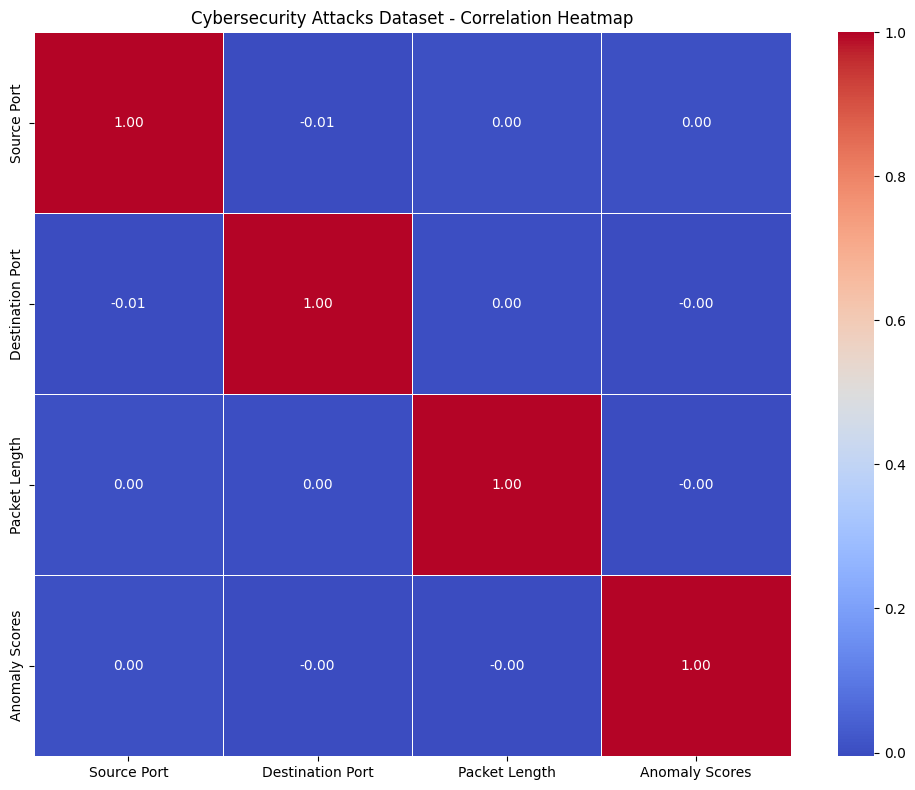

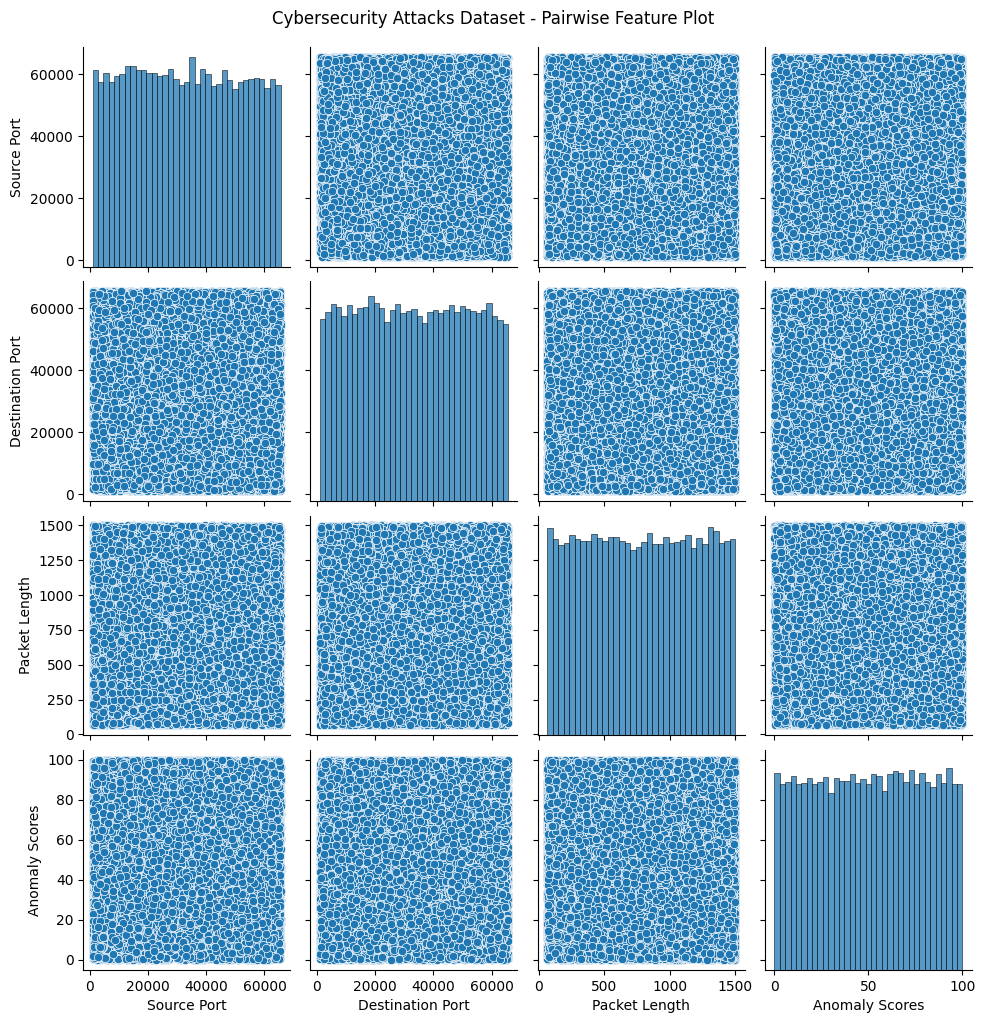

In [ ]:
cyber = pd.read_csv(cyber_attack_set)

print("Cybersecurity Attacks Dataset: EDA Heatmap and Pairplot")

# Select numeric columns
cyber_numeric = cyber.select_dtypes(include=['float64', 'int64'])

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cyber_numeric.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cybersecurity Attacks Dataset - Correlation Heatmap")
plt.tight_layout()
plt.show()

# Pairplot (subset to 5–6 features max)
cyber_pair_cols = cyber_numeric.columns[:6]
sns.pairplot(cyber[cyber_pair_cols])
plt.suptitle("Cybersecurity Attacks Dataset - Pairwise Feature Plot", y=1.02)
plt.show()


# 📊 Cybersecurity Attacks Dataset – Correlation Heatmap Analysis

This heatmap shows the Pearson correlation between selected numeric features in the Cybersecurity Attacks dataset. Each value ranges from:
- **+1.00**: Perfect positive correlation
- **-1.00**: Perfect negative correlation
- **0.00**: No linear relationship

---

## 🔍 Key Observations

### 🔴 Perfect Self-Correlation (Diagonal)
- As expected, each feature correlates perfectly with itself: `ρ = 1.00` along the diagonal.
- These values serve as a reference baseline and are not meaningful for analysis.

### ⚪ Weak or Zero Cross-Correlations
- **Source Port ↔ Destination Port**: `ρ = -0.01`  
  → Near-zero correlation suggests no meaningful linear relationship. These ports likely vary independently based on the network setup or attack structure.

- **Source Port ↔ Packet Length**: `ρ = 0.00`  
  → Indicates port number does not influence packet size, which makes sense given the random nature of port assignments in many traffic types.

- **Destination Port ↔ Packet Length**: `ρ = 0.00`  
  → Also independent. Packet length is determined by payload, not port.

- **All features ↔ Anomaly Scores**: `ρ ≈ 0.00`  
  → This is critical: it means **none of these features have a direct linear relationship** with anomaly scores.

---

## 🎯 Implications for Modeling

- The lack of strong linear correlations suggests that **simple regression or linear models will not be effective** for predicting anomaly scores.
- This aligns with the poor R² result from your earlier regression summary (R² = 0.004).
- Relationships between features and anomaly scores may be **nonlinear**, **interaction-based**, or buried in high-dimensional patterns.

---

## 🧠 Recommendations

### 1. Try Nonlinear Models
- Use **tree-based models** (e.g., Random Forest, XGBoost) or **neural networks** to uncover complex patterns not captured by correlations.

### 2. Engineer Better Features
- Create **composite features** (e.g., `is_known_port`, `packet_rate`).
- Encode categorical information (e.g., protocols, IP addresses) meaningfully if available.

### 3. Visual Pattern Discovery
- Continue exploring with **pairplots**, **boxplots**, and **grouped distributions** to spot attack-specific behavior.

### 4. Consider Anomaly Detection Approaches
- Use unsupervised models like:
  - Isolation Forest
  - Local Outlier Factor
  - Autoencoders
- These are better suited to datasets where anomalies are **subtle or context-specific**.

---

📌 **Conclusion**:
The heatmap confirms that there are **no strong linear relationships** between the selected numeric features and `Anomaly Scores`. You will likely need to go beyond traditional correlation analysis and apply **nonlinear or anomaly-focused techniques** for effective detection in this dataset.

# 🔍 Cybersecurity Attacks Dataset – Pairwise Feature Plot Analysis

This pairplot visualizes **distributions and scatterplots** between four numeric features:
- Source Port
- Destination Port
- Packet Length
- Anomaly Scores

Each diagonal shows the **distribution (histogram)** of that feature. Off-diagonal cells show **scatterplots between feature pairs**.

---

## 📊 Diagonal Histograms – Feature Distributions

### 🔢 Source Port / Destination Port
- Both show **uniform or near-uniform distributions** across the 0–65,535 range.
- This suggests:
  - Either port numbers are assigned randomly (e.g., ephemeral client ports), or
  - The dataset includes a diverse range of network behaviors.
- ⚠️ Interpretation is difficult unless specific port ranges (e.g., well-known ports) are grouped into meaningful categories (e.g., HTTP, SSH, DNS).

### 📨 Packet Length
- Also shows a fairly uniform distribution with a hard ceiling near 1,500 bytes (typical Ethernet MTU).
- Suggests the dataset includes full-packet captures, with a mix of small and maxed-out packets.

### 🚨 Anomaly Scores
- Spread from 0 to 100 with **no clear skew or peaks**.
- Implies a normalized or scaled score, possibly pre-processed by a detection system.

---

## 🔀 Off-Diagonal Scatterplots – Feature Interactions

### ⚠️ Flat and Noisy Patterns
- Every scatterplot shows a **cloud of points with no clear trend**, clusters, or relationships.
- There is **no visible structure** between `Anomaly Scores` and any of the numeric features shown.
- This confirms the **near-zero correlations** seen in the heatmap.

---

## 🎯 Interpretation and Modeling Implications

### ✖️ No Clear Linear or Visual Patterns
- These features (on their own or pairwise) do **not explain anomaly scores** in a way that could be captured by linear regression or simple rules.

### ✅ What You Should Try Next:

1. **Feature Engineering**:
   - Create **binary flags** for well-known vs. ephemeral ports.
   - Engineer features like `is_same_port`, `packet_to_port_ratio`, `frequency_score`, etc.

2. **Nonlinear Modeling**:
   - Use **tree-based models** (Random Forests, Gradient Boosting) which can capture interactions and thresholds even when patterns aren’t linear.
   - Try **unsupervised clustering or anomaly detection** (e.g., Isolation Forest, Autoencoders) to detect structure beyond human perception.

3. **Enrich the Feature Set**:
   - Consider adding protocol type, flag values, flow direction, or timing-related features if available.

4. **Label Analysis**:
   - If `Anomaly Scores` are derived from some rule-based detector, review those rules to see which dimensions were used, then mirror that logic in your model.

---

📌 **Conclusion**:
This pairplot highlights a **lack of visual signal** between numeric features and anomaly scores. While these raw features alone offer limited insight, the dataset likely requires **advanced modeling techniques**, richer feature transformations, and deeper inspection of categorical or time-based variables to improve anomaly detection.

In [4]:
#  Load and preprocess Beth dataset

# Load and preprocess Beth dataset
beth_train = pd.read_csv(beth_train_set)
beth_test = pd.read_csv(beth_test_set)

beth_train['evil'] = pd.to_numeric(beth_train['evil'], errors='coerce')
beth_train.drop(columns=['args', 'stackAddresses', 'hostName', 'processName', 'eventName'], inplace=True)
beth_train.dropna(subset=['evil'], inplace=True)

# Fix column formatting and dummy encoding
beth_train.columns = beth_train.columns.str.strip()
beth_train = pd.get_dummies(beth_train, drop_first=True)
beth_train = beth_train.astype({col: 'int64' for col in beth_train.select_dtypes('bool').columns})
beth_train.dropna(inplace=True)

y = beth_train['evil']
X = beth_train.drop(columns='evil')
X_const = sm.add_constant(X)

# Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_const = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_poly_const).fit()

# Interaction Regression
inter = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = inter.fit_transform(X)
X_inter_const = sm.add_constant(X_inter)
model_inter = sm.OLS(y, X_inter_const).fit()

# VIF
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Variance Regression
base_model = sm.OLS(y, X_const).fit()
squared_resid = base_model.resid ** 2
var_model = sm.OLS(squared_resid, X_const).fit()

print(" Beth Dataset: Polynomial Regression Summary\n")
print(model_poly.summary())

print("\n Beth Dataset: Interaction Terms Summary\n")
print(model_inter.summary())

print("\n Beth Dataset: Variance Regression Summary\n")
print(var_model.summary())

vif.head()



 Beth Dataset: Polynomial Regression Summary



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1872: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                            OLS Regression Results                            
Dep. Variable:                   evil   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 03 Aug 2025   Prob (F-statistic):                nan
Time:                        15:17:02   Log-Likelihood:                    inf
No. Observations:              763144   AIC:                              -inf
Df Residuals:                  763121   BIC:                              -inf
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1872: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                            OLS Regression Results                            
Dep. Variable:                   evil   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 03 Aug 2025   Prob (F-statistic):                nan
Time:                        15:17:03   Log-Likelihood:                    inf
No. Observations:              763144   AIC:                              -inf
Df Residuals:                  763101   BIC:                              -inf
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1872: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


,feature,VIF
0,timestamp,1.111090
1,processId,200.611455
2,threadId,200.783269
3,parentProcessId,1.194992
4,userId,3.917030


Here is a complete, structured Markdown cell analysis of your regression results on the BETH dataset. This includes explanations of your warnings (nan coefficients, inf log-likelihood, divide-by-zero), model failure reasons, and concrete next steps — all copyable into VS Code or a Jupyter Notebook:

⸻


# 🧬 BETH Dataset – Polynomial & Interaction Regression Analysis

This analysis summarizes results from Ordinary Least Squares (OLS) models using polynomial and interaction terms to predict the binary outcome `evil` in the BETH dataset (e.g., whether a behavior is malicious or benign).

---

## ⚠️ Critical Model Output Warnings

Both the **Polynomial Regression** and **Interaction-Only Regression** models produced the following:

- `R-squared: nan`  
- `F-statistic: nan`  
- `Log-Likelihood: inf`  
- `AIC/BIC: -inf`  
- `coef: 0` and `std err: 0` for all features  
- Multiple `RuntimeWarning`s: divide-by-zero, invalid value encountered in divide

---

## 🧠 Interpretation – What Went Wrong?

These results indicate **complete model failure**, for several possible reasons:

### 1. 🎯 Constant Target or Near-Zero Variance
- If `evil` is almost entirely 0s or 1s, the model may treat it as **constant**.
- Check the distribution:  
  ```python
  beth_train['evil'].value_counts(normalize=True)

2. 🧱 Severe Multicollinearity
	•	The condition number was extremely high (1.17e+17), which suggests near-perfect linear dependency between features.
	•	This breaks linear algebra operations used in regression.

3. 🧬 Redundant or Non-Informative Predictors
	•	Features like processId and threadId have VIFs over 200:
	•	These IDs are likely unique or sequential, contributing zero meaningful variance and perfect correlation with some linear combinations.
	•	✅ VIF > 10 is problematic; VIF > 100 is a guaranteed disaster in linear models.

⸻

🔍 VIF Summary – Key Offenders

Feature	VIF	Interpretation
processId	200.6	Almost perfectly collinear – should be dropped
threadId	200.8	Same issue – unique to thread, not predictive
userId	3.91	Acceptable – likely useful
parentProcessId	1.19	Acceptable – keep
timestamp	1.11	Low VIF – no immediate concern


⸻

✅ Recommended Fixes and Next Steps

🔧 1. Drop ID-Like Columns

Remove:
	•	processId, threadId, eventId, and any feature that behaves like a unique identifier

These fields inflate the feature matrix without adding predictive power.

⚙️ 2. Resample or Rebalance evil

If your target is extremely imbalanced (e.g., 99% benign), try:
	•	Undersampling the majority class
	•	Oversampling the minority class
	•	Or converting it into an anomaly detection problem

✂️ 3. Rethink Feature Engineering
	•	One-hot encoding might be exploding feature space with low signal.
	•	Try grouping rare categories, simplifying multi-hot encodings, or using embedding models for high-cardinality fields.

🧪 4. Try Tree-Based or Regularized Models
	•	Use Random Forests, Gradient Boosting, or Logistic Regression with Lasso/Ridge to:
	•	Handle high-dimensional sparse input
	•	Naturally avoid multicollinearity
	•	Offer robustness to irrelevant features

⸻

📌 Summary

Your OLS models failed because of:
	•	Multicollinearity (VIF > 200)
	•	Possibly imbalanced or constant target
	•	Redundant and non-informative features (e.g., IDs)

Before retrying regression:
	•	Remove problematic features
	•	Validate target distribution
	•	Use regularization or non-linear classifiers

Let me know if you want help rewriting the pipeline with feature selection and tree models!

Would you like an auto-filtering script to drop high-VIF or constant features from the BETH dataset before retraining?

BETH Dataset: EDA Heatmap and Pairplot


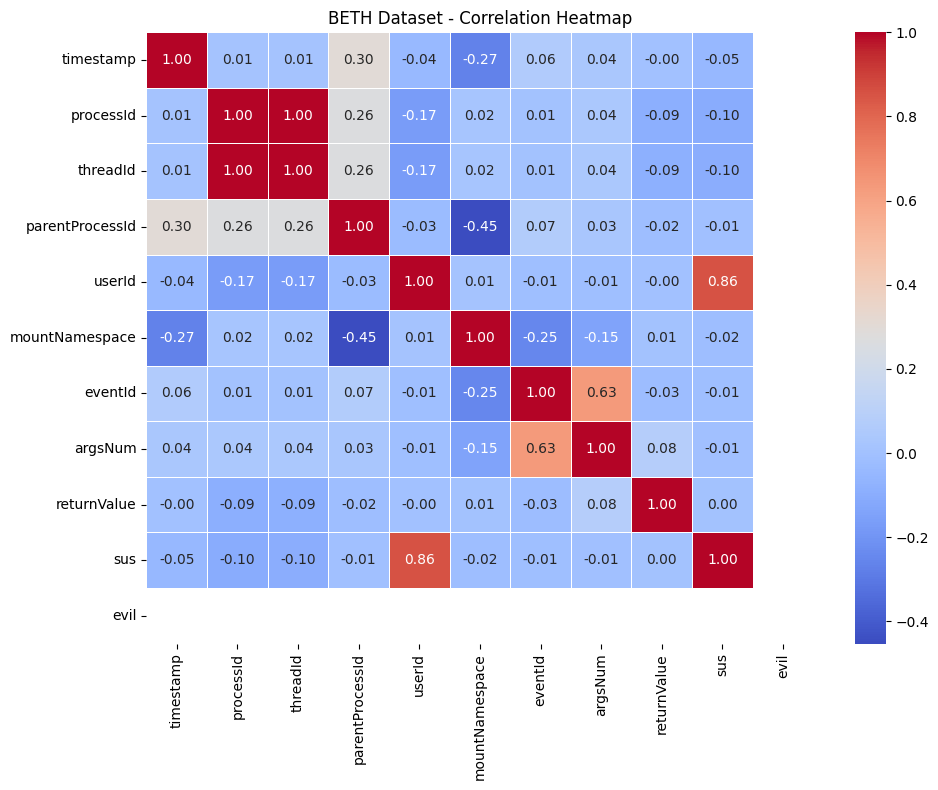

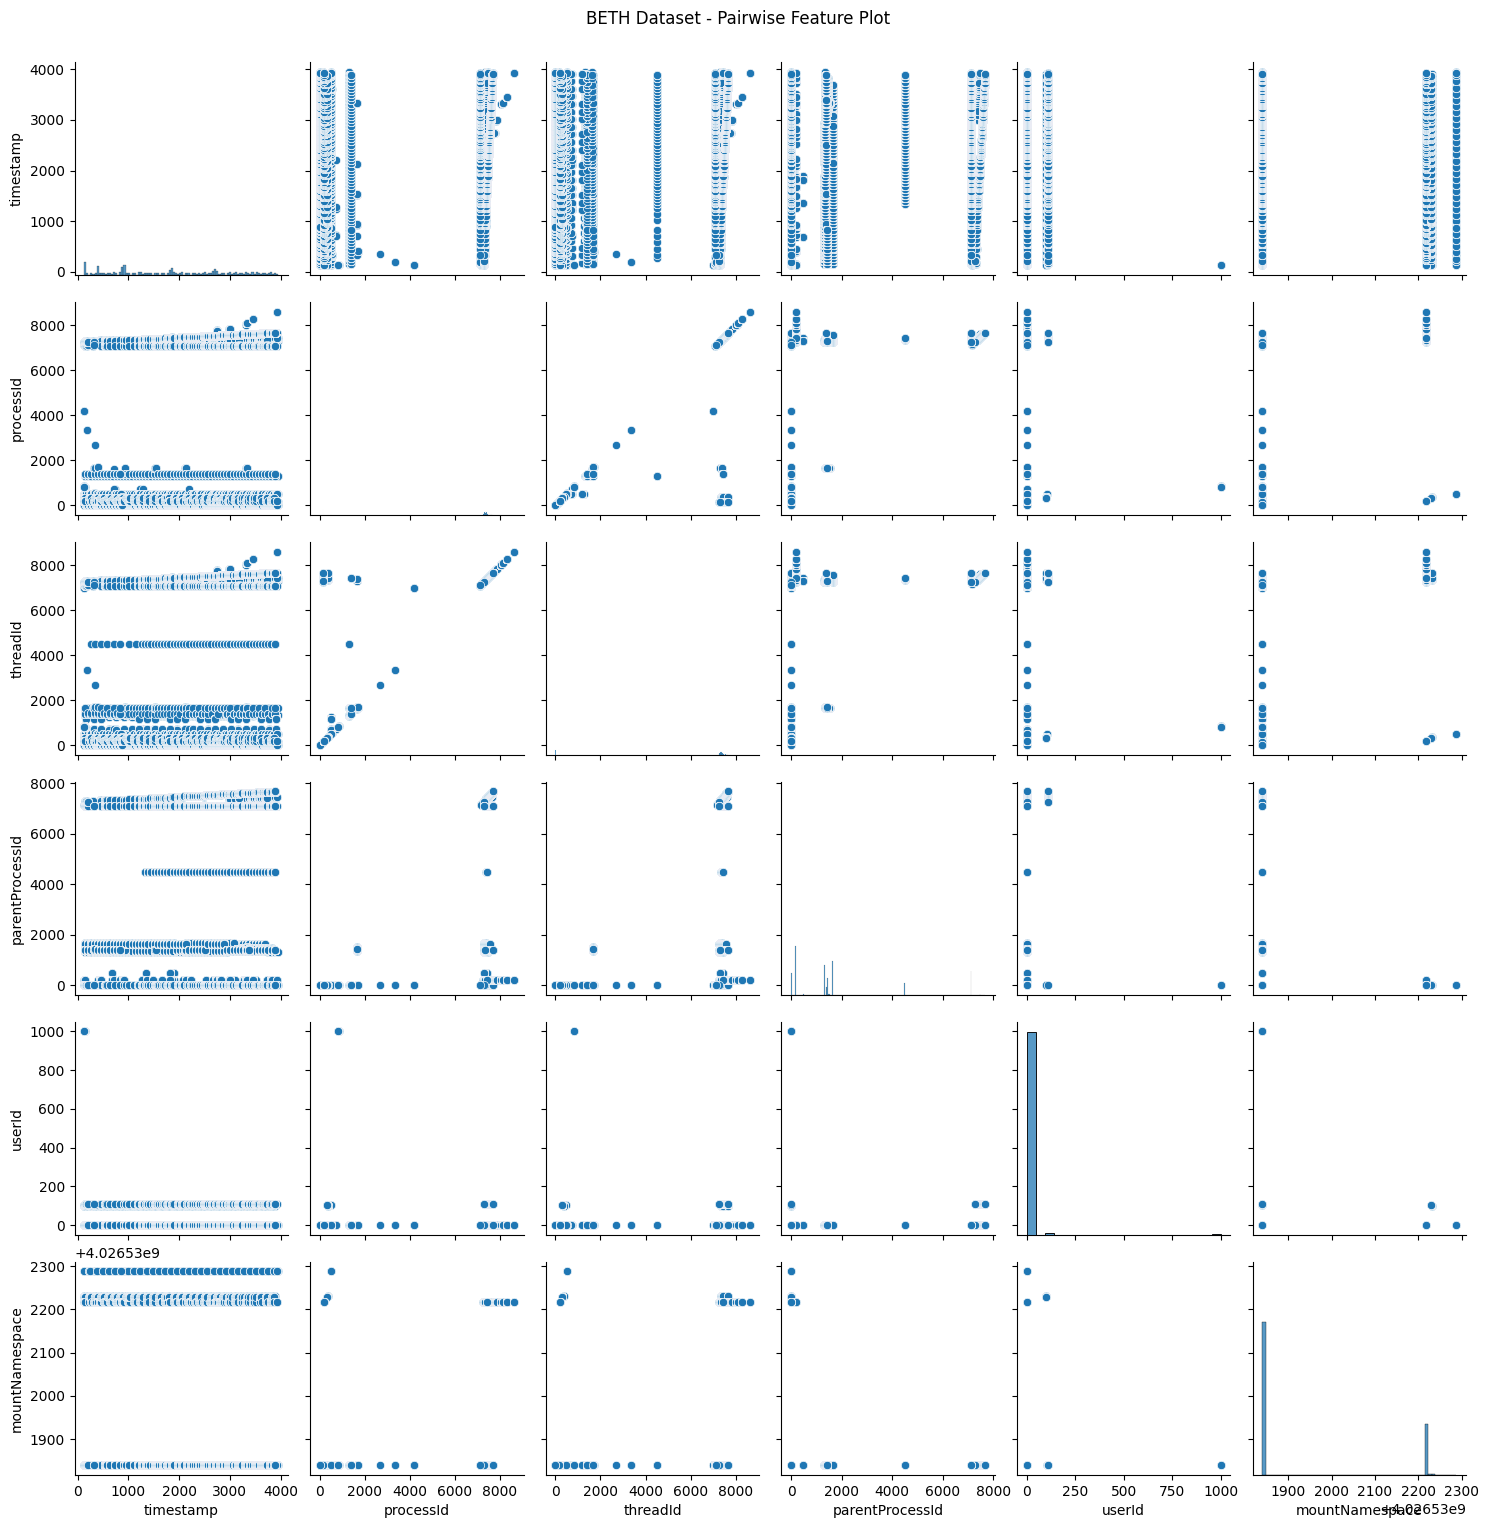

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

beth_train = pd.read_csv(beth_train_set)

# --- EDA: Heatmap & Pairplot for BETH Dataset ---
print("BETH Dataset: EDA Heatmap and Pairplot")

# Select numeric columns
beth_numeric = beth_train.select_dtypes(include=['float64', 'int64'])

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(beth_numeric.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("BETH Dataset - Correlation Heatmap")
plt.tight_layout()
plt.show()

# Pairplot (subset to 5–6 features max)
beth_pair_cols = beth_numeric.columns[:6]
sns.pairplot(beth_train[beth_pair_cols])
plt.suptitle("BETH Dataset - Pairwise Feature Plot", y=1.02)
plt.show()


# 🔍 BETH Dataset – Correlation Heatmap & Pairwise Feature Plot Analysis

This exploratory data analysis (EDA) focuses on selected numeric features in the BETH dataset, using both a correlation heatmap and pairwise scatterplots to investigate multicollinearity and potential modeling challenges.

---

## 📊 Heatmap Analysis: Feature Correlations

The correlation heatmap reveals the following key insights:

### 🔴 Very Strong Positive Correlations (ρ ≈ 1.00)
- **`processId` ↔ `threadId` (ρ = 1.00)**:
  - Perfect correlation suggests that each threadId is uniquely paired with a processId.
  - 🚨 These are likely **system-generated identifiers** — high cardinality and non-informative.
  - 📉 Should be dropped or aggregated (e.g., count per user/session).

### 🔁 Redundant Relationships
- **`parentProcessId` ↔ `processId` / `threadId` (ρ ≈ 0.26)**:
  - Moderate correlation, suggesting partial overlap but not 1:1 redundancy.

- **`sus` ↔ `userId` (ρ = 0.86)**:
  - Very strong correlation — likely derived from or redundant with `userId`.
  - If `sus` flags suspicious actions and `userId` is the attacker, this might reflect rule-based labeling.

### ⚠️ Moderate Negative Correlations
- **`mountNamespace` ↔ `timestamp` / `parentProcessId` (ρ ≈ -0.27 to -0.45)**:
  - These may reflect system hierarchy or session state changes over time.

- **`eventId` ↔ `argsNum` (ρ = 0.63)**:
  - Suggests that certain types of system calls consistently require a fixed number of arguments.

### 📉 Target Variable (`evil`)
- Not shown in the correlation matrix — likely due to it being binary or filtered during plotting.
- However, low correlation values in regression indicate that `evil` likely **cannot be predicted using individual linear relationships** alone.

---

## 🔗 Pairplot Analysis: Feature Distributions & Scatterplots

### 📈 Diagonal Histograms:
- **`processId`, `threadId`, `parentProcessId`, `userId`** show **spike-heavy or uniform discrete distributions** — consistent with ID-like behavior.
- **`mountNamespace`** appears **constant or nearly constant** across observations — not useful for prediction.

### 🔲 Off-Diagonal Scatterplots:
- Most pairwise plots form **vertical or diagonal stripes**, meaning:
  - High cardinality or categorical nature of fields (e.g., IDs)
  - Little to no continuous structure or trend

- **`processId` ↔ `threadId`**: Points lie exactly on the diagonal — confirms their 1:1 mapping.
- **`timestamp`** is dense around lower values and not evenly distributed — suggests front-loaded logging or trimmed logs.

---

## 🧠 Modeling Implications & Recommendations

### 🚫 Remove or Transform High-VIF Features
- `processId`, `threadId`, and possibly `parentProcessId` are **not suitable as predictors** in regression.
- Drop them or replace them with **session-level aggregates**, like:
  - Number of events per process
  - Time between events

### ⚠️ Remove Constant or Near-Constant Fields
- `mountNamespace` has very low variance — should be removed.

### ✅ Feature Engineering Suggestions:
- Create meaningful interaction flags (e.g., `userId + eventType`)
- Add temporal features like `time_since_last_event`
- Encode categories like `eventId` with embedding or frequency encoding

### 🤖 Modeling Tip:
- Given lack of strong individual predictors and high cardinality:
  - Use **tree-based models** (Random Forests, Gradient Boosting)
  - Try **unsupervised clustering** or **autoencoders** for pattern discovery

---

📌 **Conclusion**:
The BETH dataset contains several **identifier-like features with high multicollinearity**, making them poor predictors for traditional regression. Your EDA justifies dropping or transforming these fields and moving toward **nonlinear or unsupervised methods** that can leverage the dataset’s latent structure.